# K-Nearest Neighbors (k-NN)

In this chapter, we describe the k-nearest-neighbors algorithm that can be used for classification (of a categorical outcome) or prediction (of a numerical outcome). To classify or predict a new record, the method relies on finding "similar" records in the training data. These "neighbors" are then used to derive a classification or prediction for the new record by voting (for classification) or averaging (for prediction). We explain how similarity is determined, how the number of neighbors is chosen, and how a classification or prediction is computed. k-NN is a highly automated data-driven method. We discuss the advantages and weaknesses of the k-NN method in terms of performance and practical considerations such as computational time.

## Imports

Imports required for this notebook

In [1]:
import pandas as pd
import matplotlib.pylab as plt

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier

## The k-NN Classifier (Categorical Outcome)

The idea in *k*-nearest-neighbors methods is to identify *k* records in the training dataset that are similar to a new record that we wish to classify. We then use these similar (neighboring) records to classify the new record into a class, assigning the new record to the predominant class among these neighbors. Denote the values of the predictors for this new record by $x_1$, $x_2$, ..., $x_p$. We look for records in our training data that are similar or "near" the record to be classified in the predictor space (i.e., records that have values close to $x_1$, $x_2$, ..., $x_p$). Then, based on the classes to which those proximate records belong, we assign a class to the record that we want to classify.

### Determining Neighbors

The k-nearest-neighbors algorithm is a classification method that does not make assumptions about the form of the relationship between the class membership (*Y*) and the predictors $X_1$, $X_2$, ..., $X_p$. This is a nonparametric method because it does not involve estimation of parameters in an assumed function form, such as the linear form assumed in [linear regression](./multiple-linear-regression.ipynb). Instead, this method draws information from similarities between the predictor values of the records in the dataset.

A central question is how to measure the distance between records based on their predictor values. The most popular measure of distance is the Euclidean distance. The Euclidean distance between two records ($x_1$, $x_2$, ..., $x_p$) and ($u_1$, $u_2$, ..., $u_p$) is:

<p>
    <center>
        $\sqrt{(x_1 - u_1)^2 + (x_2 - u_2)^2 + ... + (x_p - u_p)^2}$
    </center>
</p>

You will find a host of other distance metrics elsewhere, for both numerical and categorical variables. However, the *k*-NN algorithm relies on many distance computations (between each record to be predicted and every record in the training set), and therefore the Euclidean distance, which is computationally cheap, is the most popular in *k*-NN.

To equalize the scales that the various predictors may have, note that in most cases, predictors should first be standardized before computing a Euclidean distance. Also note that the means and standard deviations used to standardize new records are those of the *training* data, and the new record is not included in calculating them. The validation data, like new data, are also not included in this calculation.

### Classification Rule

After computing the distances between the record to be classified and existing records, we need a rule to assign a class to the record to be classified, based on the classes of its neighbors. The simplest case is *k* = 1, where we look for the record that is closest (the nearest neighbor) and classify the new record as belonging to the same class as its closest neighbor. It is a remarkable fact that this simple, intuitive idea of using a single nearest neighbor to classify records can be very powerful when we have a large number of records in our training set. It turns out that the misclassification error of the 1-nearest neighbor scheme has a misclassification rate that is no more than twice the error when we know exactly the probability density functions for each class.

The idea of the *1-nearest neighbor* can be extended to *k* > 1 neighbors as follows:

1. Find the nearest *k* neighbors to the record to be classified.

2. Use a majority decision rule to classify the record, where the record is classified as a member of the majority class of the *k* neighbors.

## Example: Riding Mowers

A riding-mower manufacturer would like to find a way of classifying families in a city into those likely to purchase a riding mower and those not likely to buy one. A pilot random sample is undertaken of 12 owners and 12 nonowners in the city. The data are shown below. We first partition the data into training data (14 households) and validation data (10 households). Obviously, this dataset is too small for partitioning, which can result in unstable results, but we will continue with this partitioning for illustration purposes. A scatter plot of the training data is also shown below.

Now consider a new household with \\$60,000 income and lot size 20,000 ft² (star marker on the figure). Among the households in the training set, the one closest to the new household (in Euclidean distance after normalizing income and lot size) is household 4, with \\$61,500 income and lot size 20,800 ft² . If we use a 1-NN classifier, we would classify the new household as an owner, like household 4. If we use *k* = 3, the three nearest households are 4,
14, and 1, as can be seen visually in the scatter plot, and as computed by the software. Two of these neighbors are owners of riding mowers, and one is a nonowner. The majority vote is therefore *owner*, and the new household would be classified as an owner.

In [2]:
mower_df = pd.read_csv("../datasets/RidingMowers.csv")
mower_df["Number"] = mower_df.index + 1

## new household
new_household = pd.DataFrame({"Income": [60], "Lot_Size": [20],
                              "Number": [25], "Ownership": ["?"]})

pd.concat([mower_df, new_household])[["Income", "Lot_Size", "Ownership"]]

,Income,Lot_Size,Ownership
0,60.0,18.4,Owner
1,85.5,16.8,Owner
2,64.8,21.6,Owner
3,61.5,20.8,Owner
4,87.0,23.6,Owner
5,110.1,19.2,Owner
6,108.0,17.6,Owner
7,82.8,22.4,Owner
8,69.0,20.0,Owner
9,93.0,20.8,Owner


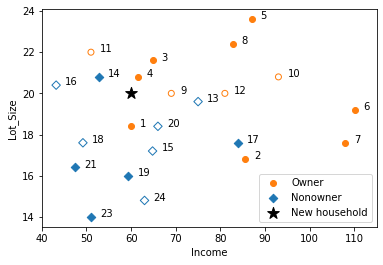

In [3]:
train_data, valid_data = train_test_split(mower_df, test_size=0.4,
                                          random_state=26)
## scatter plot
def plot_dataset(ax, data, show_label=True, **kwargs):
    subset = data.loc[data["Ownership"]=="Owner"]
    ax.scatter(subset.Income, subset.Lot_Size, marker="o",
               label="Owner" if show_label else None, color="C1", **kwargs)
    subset = data.loc[data["Ownership"]=="Nonowner"]
    ax.scatter(subset.Income, subset.Lot_Size, marker="D",
               label="Nonowner" if show_label else None, color="C0", **kwargs)
    plt.xlabel("Income") # set x-axis label
    plt.ylabel("Lot_Size") # set y-axis label
    for _, row in data.iterrows():
        ax.annotate(row.Number, (row.Income + 2, row.Lot_Size))

fig, ax = plt.subplots()
plot_dataset(ax, train_data)
plot_dataset(ax, valid_data, show_label=False, facecolors="none")
ax.scatter(new_household.Income, new_household.Lot_Size, marker="*",
           label="New household", color="black", s=150)
plt.xlabel("Income"); plt.ylabel("Lot_Size")
ax.set_xlim(40, 115)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc=4)
plt.show()

In [4]:
# initialize normalized training, validation, and complete data frames
# use the training data to learn the transformation.
scaler = preprocessing.StandardScaler()
scaler.fit(train_data[["Income", "Lot_Size"]]) # Note the use of array of column names

# transform the full dataset
mower_norm = pd.concat([pd.DataFrame(scaler.transform(mower_df[["Income", "Lot_Size"]]),
                                     columns=["zIncome", "zLot_Size"]),
                        mower_df[["Ownership", "Number"]]], axis=1)

train_norm = mower_norm.iloc[train_data.index]
valid_norm = mower_norm.iloc[valid_data.index]

## new household
new_household = pd.DataFrame({"Income": [60], "Lot_Size": [20]})
new_household_norm = pd.DataFrame(scaler.transform(new_household),
                                  columns=["zIncome", "zLog_Size"])

# user NearestNeighbors from scikit-learn to compute knn
knn = NearestNeighbors(n_neighbors=3)
knn.fit(train_norm.iloc[:, 0:2])
distances, indices = knn.kneighbors(new_household_norm)

# indices is a list of lists, we are only interested in the first element
train_norm.iloc[indices[0], :]

,zIncome,zLot_Size,Ownership,Number
3,-0.409776,0.743358,Owner,4
13,-0.804953,0.743358,Nonowner,14
0,-0.477910,-0.174908,Owner,1


### Choosing k

The advantage of choosing *k* > 1 is that higher values of *k* provide smoothing that reduces the risk of overfitting due to noise in the training data. Generally speaking, if *k* is too low, we may be fitting to the noise in the data. However, if *k* is too high, we will miss out on the method's ability to capture the local structure in the data, one of its main advantages. In the extreme, *k* = *n* = the number of records in the training dataset. In that case, we simply assign all records to the majority class in the training data,irrespective of the values of ($x_1$, $x_2$, ...,$x_p$), which coincides with the naive rule! This is clearly a case of oversmoothing in the absence of useful information in the predictors about the class membership. In other words, we want to balance between overfitting to the predictor information and ignoring this information completely. A balanced choice greatly depends on the nature of the data. The more complex and irregular the structure of the data, the lower the optimum value of *k*. Typically, values of *k* fall in the range of 1-20. We will use odd numbers to avoid ties.

So how is *k* chosen? Answer: We choose the *k* with the best classification performance. We use the training data to classify the records in the validation data, then compute error rates for various choices of *k*. For our example, if we choose *k* = 1, we will classify in a way that is very sensitive to the local characteristics of the training data. On the other hand, if we choose a large value of *k*, such as *k* = 14, we would simply predict the most frequent class in the dataset in all cases. This is a very stable prediction but it completely ignores the information in the predictors. To find a balance, we examine the accuracy (of predictions in the validation set) that results from different choices of *k* between 1 and 14. For an even number *k*, if there is a tie in classifying a household, the tie is broken randomly. This is shown in the table below.

In [5]:
train_X = train_norm[["zIncome", "zLot_Size"]]
train_y = train_norm["Ownership"]
valid_X = valid_norm[["zIncome", "zLot_Size"]]
valid_y = valid_norm["Ownership"]

# Train a classifier for different values of k
results = []
for k in range(1, 15):
    knn = KNeighborsClassifier(n_neighbors=k).fit(train_X, train_y)
    results.append({"k": k,
                    "accuracy": accuracy_score(valid_y, knn.predict(valid_X))})

# Convert results to a pandas data frame
results = pd.DataFrame(results)
results

,k,accuracy
0,1,0.6
1,2,0.7
2,3,0.8
3,4,0.9
4,5,0.7
5,6,0.9
6,7,0.9
7,8,0.9
8,9,0.9
9,10,0.8


Best *k* is 4!

Once *k* is chosen, we rerun the algorithm on the combined training and testing sets in order to generate classifications of new records. An example is shown below, where the four nearest neighbors are used to classify the new household.

In [6]:
# Retrain with full dataset
mower_X = mower_norm[["zIncome", "zLot_Size"]]
mower_y = mower_norm["Ownership"]
knn = KNeighborsClassifier(n_neighbors=4).fit(mower_X, mower_y)

distances, indices = knn.kneighbors(new_household_norm)
print("Predicted Ownership:", knn.predict(new_household_norm))
print("Distances:", distances)
print("Indices:", indices)
print(mower_norm.iloc[indices[0], :])

Predicted Ownership: ['Owner']
Distances: [[0.31358009 0.40880312 0.44793643 0.61217726]]
Indices: [[ 3  8 13  0]]
     zIncome  zLot_Size Ownership  Number
3  -0.409776   0.743358     Owner       4
8  -0.069107   0.437269     Owner       9
13 -0.804953   0.743358  Nonowner      14
0  -0.477910  -0.174908     Owner       1


### Setting the Cutoff Value

*k*-NN uses a majority decision rule to classify a new record, where the record is classified as a member of the majority class of the *k* neighbors. The definition of "majority" is directly linked to the notion of a cutoff value applied to the class membership probabilities. Let us consider a binary outcome case.For a new record, the proportion of class 1 members among its neighbors is an estimate of its propensity (probability) of belonging to class 1. In the riding mowers example with *k* = 4, we found that the four nearest neighbors to the new household (with income = \\$60,000 and lot size = 20,000 ft²) are households 4, 9, 14, and 1.

Since three of these are owners and one is a nonowner, we can estimate for the new household a probability of 0.75 of being an owner (and 0.25 for being a nonowner). Using a simple majority rule is equivalent to setting the cutoff value to 0.5. In the above results, we see that the software assigned class *owner* to this record.

As mentioned in [Evaluating Prediction Performance](./evaluating-predictive-performance.ipynb), changing the cutoff value affects the confusion matrix (i.e., the error rates). Hence, in some cases we might want to choose a cutoff other than the default 0.5 for the purpose of maximizing accuracy or for incorporating misclassification costs.

### k-NN with More Than Two Classes

The k-NN classifier can easily be applied to an outcome with *m* classes, where *m* > 2. The "majority rule" means that a new record is classified as a member of the majority class of its *k* neighbors. An alternative, when there is a specific class that we are interested in identifying (and are willing to "overidentify" records as belonging to this class), is to calculate the proportion of the *k* neighbors that belong to this class of interest, use that as an estimate of the probability (propensity) that the new record belongs to that class, and then refer to a user-specified cutoff value to decide whether to assign the new record to that class. For more on the use of cutoff value in classification where there is a single class of interest, see [Evaluating Prediction Performance](./evaluating-predictive-performance.ipynb)

### Converting Categorical Variables to Binary Dummies

It usually does not make sense to calculate Euclidean distance between two non-numeric categories (e.g., cookbooks and maps, in a bookstore). Therefore, before *k*-NN can be applied, categorical variables must be converted to binary dummies. In contrast to the situation with statistical models such as regression, all *m* binaries should be created and used with *k*-NN. While mathematically this is redundant, since *m* - 1 dummies contain the same information as *m* dummies, this redundant information does not create the multicollinearity problems that it does for linear models. Moreover, in *k*-NN the use of *m* - 1 dummies can yield different classifications than the use of *m* dummies, and lead to an imbalance in the contribution of the different categories to the model.